# 逻辑回归简述(Logistic Regression)

logistic回归是一种广义线性回归（generalized linear model），因此与多重线性回归分析有很多相同之处。它们的模型形式基本上相同，都具有 w‘x+b，其中w和b是待求参数，其区别在于他们的因变量不同，多重线性回归直接将w‘x+b作为因变量，即y =w‘x+b，而logistic回归则通过函数L将w‘x+b对应一个隐状态p，p =L(w‘x+b),然后根据p 与1-p的大小决定因变量的值

## 处理过程常用步骤
1. 收集数据， 数据清理， 数据拆分
2. 初始化模型和参数
3. 训练和测试, 评估模型

## 问题 (酒店是否预定)
根据用户事件的搜索和与该用户事件相关联的其他属性来预测用户事件的事件结果（预订或者没有预定）
转载至[Towards Data Science](https://towardsdatascience.com/predicting-hotel-bookings-with-user-search-parameters-8c570ab24805)

### 数据收集与清洗
数据来源: [kaggle](https://www.kaggle.com/c/expedia-hotel-recommendations/data)
![booking](images/booking.png)


In [1]:
import pandas as pd

df = pd.read_csv("data/train.csv.gz", sep=',').dropna()
df = df.sample(frac=0.01, random_state=99)
df.shape

(241179, 24)

查看预定与没有预定的分布

Text(0,0.5,'Frequency')

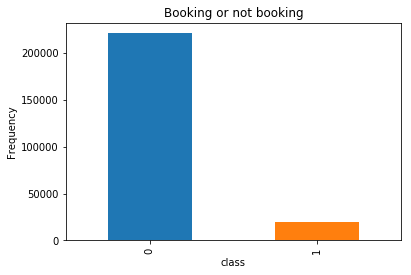

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

count_class = pd.value_counts(df['is_booking'], sort=True).sort_index()
count_class.plot(kind='bar')
plt.title("Booking or not booking")
plt.xlabel("class")
plt.ylabel("Frequency")

观察上图，可知分布十分不均匀， 处理一波,  将样本数量保持一致

Text(0,0.5,'Frequency')

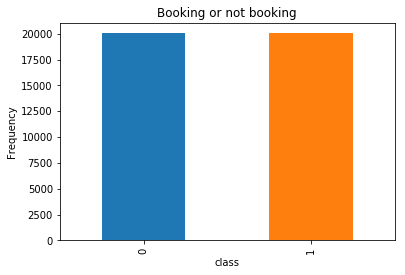

In [24]:
import numpy as np

booking_indices = df[df['is_booking'] == 1].index
random_indices = np.random.choice(booking_indices,
                                 len(df.loc[df.is_booking == 1]),
                                 replace=False)

booking_sample = df.loc[random_indices]
not_booking = df[df['is_booking'] == 0].index
random_indices = np.random.choice(not_booking,
                                 sum(df['is_booking']),
                                 replace=False)
nbooking_sample = df.loc[random_indices]

df_new=pd.concat([nbooking_sample, booking_sample])
df_new = df_new.sample(frac=1).reset_index(drop=True)
count_class = pd.value_counts(df_new['is_booking'], sort=True).sort_index()
count_class.plot(kind='bar')
plt.title("Booking or not booking")
plt.xlabel("class")
plt.ylabel("Frequency")

去除无用的列

In [25]:
df_new['date_time'] = pd.to_datetime(df_new['date_time'])
df_new['year'] = df_new['date_time'].dt.year
df_new['month'] = df_new['date_time'].dt.month

df_new['srch_ci']=pd.to_datetime(df_new['srch_ci'],infer_datetime_format = True,errors='coerce')
df_new['srch_co']=pd.to_datetime(df_new['srch_co'],infer_datetime_format = True,errors='coerce')

df_new['plan_time'] = ((df_new['srch_ci'] - df_new['date_time']) / np.timedelta64(1,'D')).astype(float)
df_new['hotel_nights']=((df_new['srch_co'] - df_new['srch_ci']) / np.timedelta64(1,'D')).astype(float)
cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
df_new.drop(cols_to_drop, axis=1, inplace=True)

将预定数据列拆分

In [29]:
x = df_new.loc[:, df_new.columns != 'is_booking']
y = df_new.loc[:, df_new.columns == 'is_booking']

查看各个特征的相关性

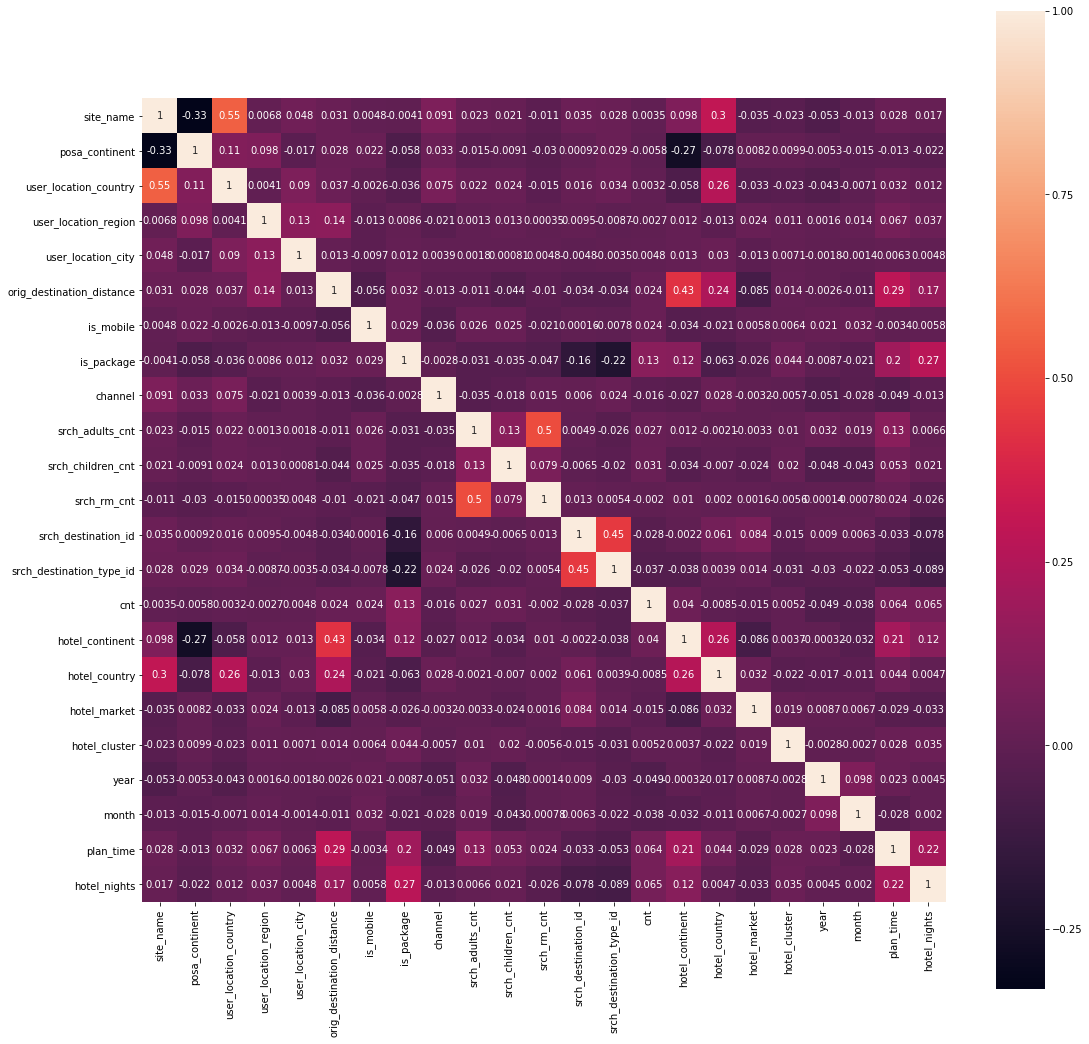

In [31]:
import seaborn as sns

correlation = x.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, square=True,annot=True)

由上图所知， 各特征间的相关性不是特别强

**关于特征的选取采用PCA**      
*PCA*: Principal component analysis是一种统计技术，通过选择捕获有关数据集的最大信息的最重要特征，将高维数据转换为低维数据。我们希望PCA能帮助我们找出具有最大差异的特征， 并且可视化表现出来
***
** 数据归一化 ** [再谈机器学习中的归一化方法](https://blog.csdn.net/zbc1090549839/article/details/44103801)
1. 线性函数归一化(Min-Max scaling):  线性函数将原始数据线性化的方法转换到[0, 1]的范围， 公式如下: $X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$
2. 0均值标准化: 0均值归一化方法将原始数据集归一化为均值为0， 方差1的数据集， 公式如下: $z = \frac{x - \mu}{\sigma}$ 

选择标准:
1. 在分类， 聚类算法中，需要使用距离来度量相似性的时候，在分类、聚类算法中，需要使用距离来度量相似性的时候、或者使用PCA技术进行降维的时候，第二种方法(Z-score standardization)表现更好。
2. 在不涉及距离度量、协方差计算、数据不符合正太分布的时候，可以使用第一种方法或其他归一化方法。比如图像处理中，将RGB图像转换为灰度图像后将其值限定在[0 255]的范围。


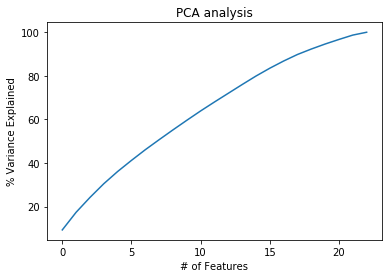

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 规范数据 
scaler = StandardScaler()
X = scaler.fit_transform(x)

# 应用pca， 23个特征
pca = PCA(n_components=23)
pca.fit(X)

# 计算特征值(特征累计和)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA analysis')

plt.plot(var)


根据图可知， 我们应该保留23个特征

##  初始化模型和参数

### 逻辑回归

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score


# 初始化模型， 参数
X_train, X_test, y_train, y_test = train_test_split(X, y['is_booking'], test_size=0.3, random_state=1)
pca = PCA(n_components=23)
logReg = LogisticRegression()
pipe = Pipeline([('pca', pca), ('logistic', logReg)])

# 训练
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Intercept:', logReg.intercept_[0])
print(pd.DataFrame({'features': x.columns, 'coeficents': logReg.coef_[0]}))

# 评估
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))


Intercept: -0.4187428379444224
    coeficents                   features
0     0.452314                  site_name
1     0.502236             posa_continent
2    -0.156908      user_location_country
3     0.209885       user_location_region
4     0.264039         user_location_city
5    -0.793648  orig_destination_distance
6     0.807912                  is_mobile
7     0.055783                 is_package
8    -0.156919                    channel
9     0.353093            srch_adults_cnt
10   -0.753359          srch_children_cnt
11   -0.181534                srch_rm_cnt
12   -0.860151        srch_destination_id
13   -0.970880   srch_destination_type_id
14   -1.412114                        cnt
15   -0.259000            hotel_continent
16   -0.242571              hotel_country
17    0.292450               hotel_market
18    0.203172              hotel_cluster
19    0.066239                       year
20    0.189033                      month
21    0.046080                  plan_time
22 